<a href="https://colab.research.google.com/github/huangwenbing4github/keras_demo/blob/main/cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   106M      0  0:00:07  0:00:07 --:--:--  113M


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
!unzip -q kaggle*

In [6]:
import os 
for folder_name in ['Cat','Dog']:
  folder_path = os.path.join('PetImages',folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path,fname)
    try:
      fobj = open(fpath,'rb')
      is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
    finally:
      fobj.close()
    if not is_jfif:
      os.remove(fpath)
      #print(fpath)
    

In [7]:
image_size = (180,180)
batch_size = 128

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='both',
    seed=1337,
    image_size=image_size,
    batch_size = batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [8]:
for images,labels in train_ds.take(1):
  for i in range(2):
    print(images[i])

tf.Tensor(
[[[121.63013  137.63013  124.63013 ]
  [120.37778  136.37778  123.37778 ]
  [121.82222  137.82222  124.82222 ]
  ...
  [255.       255.       240.72096 ]
  [253.89035  255.       236.53775 ]
  [253.81111  254.81111  238.81111 ]]

 [[117.701485 133.70148  120.701485]
  [115.566666 131.56667  118.566666]
  [115.566666 131.56667  118.566666]
  ...
  [255.       255.       242.43333 ]
  [254.4711   255.       241.80002 ]
  [254.43333  254.8237   242.90964 ]]

 [[120.36667  136.36667  123.36667 ]
  [116.98889  132.98889  119.98889 ]
  [116.05556  132.05556  119.05556 ]
  ...
  [255.       255.       244.11115 ]
  [255.       255.       245.15556 ]
  [255.       254.05556  249.11111 ]]

 ...

 [[114.08183  122.19298  111.19298 ]
  [124.78182  136.78183  124.91516 ]
  [122.85157  138.75896  128.23427 ]
  ...
  [170.52486  189.52486  193.52486 ]
  [174.25197  195.24457  198.24826 ]
  [181.43703  202.43703  205.51358 ]]

 [[ 80.09286   87.52621   78.22616 ]
  [ 69.65316   81.61538   

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])
train_ds = train_ds.map(
    lambda image,label:(data_augmentation(image),label),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [10]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

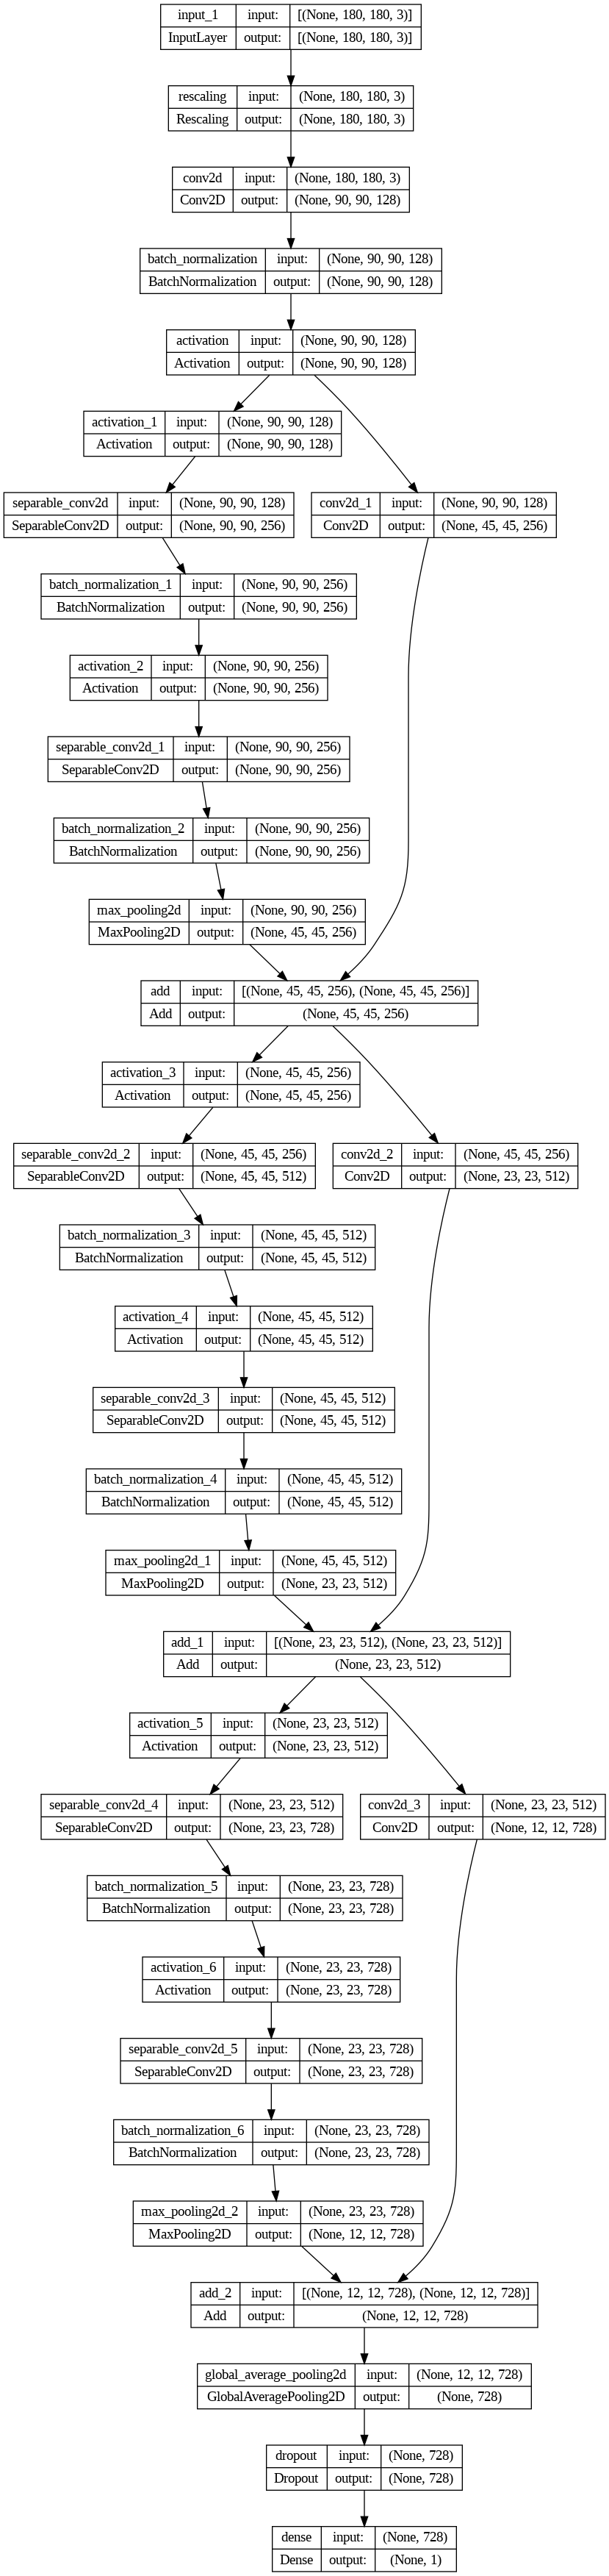

In [11]:
def make_model(input_shape, num_classes):
  _r = 'relu'
  inputs = keras.Input(shape=input_shape)
  x = layers.Rescaling(1.0/255)(inputs)
  x = layers.Conv2D(128,3,strides=2,padding='same')(x)#卷积
  x = layers.BatchNormalization()(x)
  x = layers.Activation(_r)(x)

  previous_block_activation = x

  for size in [256,512,728]:
    for _ in range(2):
      x = layers.Activation(_r)(x)
      x = layers.SeparableConv2D(size,3,padding='same')(x)
      x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2,padding='same')(x)
    residual = layers.Conv2D(size,1,strides=2,padding='same')(previous_block_activation)
    x = layers.add([x,residual])
    previous_block_activation = x
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size+(3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

In [12]:
epochs = 25
callbacks = [keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds)

Epoch 1/25
147/147 [==============================] - 249s 1s/step - loss: 0.8459 - accuracy: 0.5878 - val_loss: 0.6929 - val_accuracy: 0.5051
Epoch 2/25
147/147 [==============================] - 207s 1s/step - loss: 0.6448 - accuracy: 0.6498 - val_loss: 0.6915 - val_accuracy: 0.5449
Epoch 3/25
147/147 [==============================] - 207s 1s/step - loss: 0.5613 - accuracy: 0.7148 - val_loss: 0.6849 - val_accuracy: 0.5831
Epoch 4/25
147/147 [==============================] - 209s 1s/step - loss: 0.4999 - accuracy: 0.7612 - val_loss: 0.7489 - val_accuracy: 0.5271
Epoch 5/25
147/147 [==============================] - 209s 1s/step - loss: 0.4243 - accuracy: 0.8059 - val_loss: 0.5590 - val_accuracy: 0.7330
Epoch 6/25
147/147 [==============================] - 208s 1s/step - loss: 0.3660 - accuracy: 0.8420 - val_loss: 0.5924 - val_accuracy: 0.7240
Epoch 7/25
147/147 [==============================] - 208s 1s/step - loss: 0.3218 - accuracy: 0.8630 - val_loss: 0.3122 - val_accuracy: 0.8699

In [25]:
!wget https://cn.bing.com/images/search?view=detailV2&ccid=bGhGZ%2bcn&id=B69DDF8819C65BA94E94DE0DC142F638F18C596B&thid=OIP.bGhGZ-cnG6uTrKyJ3RehQwHaJ3&mediaurl=https%3a%2f%2fpic.3gbizhi.com%2f2019%2f0927%2f20190927123527957.jpeg&exph=2133&expw=1600&q=%e7%8c%ab%e7%8b%97%e7%85%a7%e7%89%87&simid=608002374120252055&FORM=IRPRST&ck=01EFA87A3696766EC942D850DE5C8D04&selectedIndex=81&ajaxhist=0&ajaxserp=0

--2023-04-11 06:24:20--  https://cn.bing.com/images/search?view=detailV2
Resolving cn.bing.com (cn.bing.com)... 204.79.197.200, 13.107.21.200
Connecting to cn.bing.com (cn.bing.com)|204.79.197.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629961 (615K) [text/html]
Saving to: ‘search?view=detailV2.1’

search?view=detailV 100%[===================>] 615.20K  --.-KB/s    in 0.05s   

2023-04-11 06:24:20 (11.7 MB/s) - ‘search?view=detailV2.1’ saved [629961/629961]



In [26]:
!cp search?view=detailV2 random2.jpg

In [24]:
img = keras.preprocessing.image.load_img('random1.jpg', target_size=image_size)

UnidentifiedImageError: ignored

In [21]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 23ms/step
[[0.0270129]]
